# Latent optimization with e4e, styleGAN and CLIP

## 1. Load pretrained pSp

In [1]:
from argparse import Namespace
import time
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.amp import autocast
from tqdm import tqdm
import clip

from utils.common import tensor2im
from utils.alignment import run_alignment
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.
from criteria.clip_loss import CLIPLoss
from criteria.id_loss import IDLoss

%load_ext autoreload
%autoreload 2
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_PATH = "input_images/input_img.jpg"
RESIZE_DIMS = (256, 256)

In [2]:
# Define the arguments for the e4e encoder

pretrained_pSp_path = 'pretrained_models/e4e_ffhq_encode.pt'

e4e_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
)

In [5]:
# Load the pSp model

ckpt = torch.load(pretrained_pSp_path, map_location='cpu')
opts = ckpt['opts']
opts['checkpoint_path'] = pretrained_pSp_path
opts['ir_se50_weights'] = 'pretrained_models/model_ir_se50.pth'
opts= Namespace(**opts)
latent_avg = ckpt["latent_avg"]

psp_model = pSp(opts)
psp_model.eval()
psp_model.cuda()

print('Model successfully loaded!')

/tmp/ipykernel_1776013/3793385928.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(pretrained_pSp_path, map_location='cpu')


Loading e4e over the pSp framework from checkpoint: pretrained_models/e4e_ffhq_encode.pt
Model successfully loaded!


## 2. Latent optimization with CLIP loss

Given a source latent code $w_s \in W^+$, and a directive in natural language, or a text prompt $t$, we solve the following optimization problem:

$$ argmin_{w \in \mathbb W^+} \, D_{CLIP}(G(w), t) + \lambda_{L2} \left\| w - w_s \right\|_2 + \lambda_{ID} \mathcal L_{ID}(w) $$

where $G$ is a pretrained StyleGAN generator and $D_{CLIP}$ is the cosine distance between the CLIP embeddings of its two arguments. Similarity to the input image is controlled by the $L^2$ distance in latent space, and by the identity loss:

$$ \mathcal{L}_{ID}(w) = 1 - \langle R(G(w_s)), R(G(w)) \rangle $$

where $R$ is a pretrained ArcFace network for face recognition, and $ \langle \cdot , \cdot \rangle $ computes the cosine similarity between its arguments.



Aligned image has shape: (256, 256)


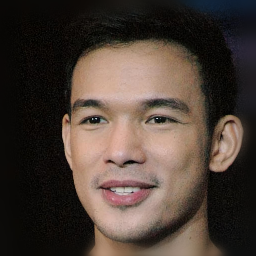

In [6]:
# Define the image

image_path = IMAGE_PATH
original_image = Image.open(image_path).convert("RGB")
image = run_alignment(image_path).resize(RESIZE_DIMS)

# show the input image
input_image = e4e_transform(image)
image


In [7]:
# compute w_start

with torch.no_grad():
    w_s = psp_model.encoder(input_image.unsqueeze(0).to(device))
if psp_model.opts.start_from_latent_avg:
                if w_s.ndim == 2:
                    w_s = w_s + psp_model.latent_avg.repeat(w_s.shape[0], 1, 1)[:, 0, :]
                else:
                    w_s = w_s + psp_model.latent_avg.repeat(w_s.shape[0], 1, 1)
print(w_s.shape)

torch.Size([1, 18, 512])


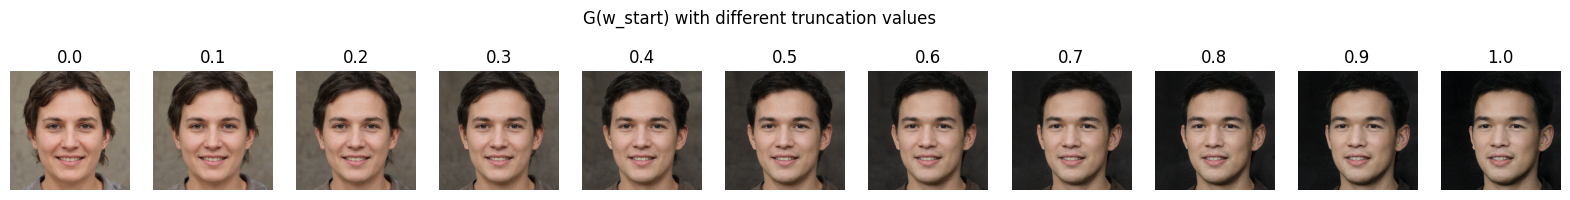

In [8]:
# Visualize G(w_s) with different truncation values

plt.figure(figsize=(20, 2.5))

for i, truncation in enumerate(np.linspace(0, 1, 11)):
    with torch.no_grad():
        with torch.amp.autocast("cuda"):
            generated_image, _ = psp_model.decoder([w_s], input_is_latent=True,
                                                    truncation=truncation,
                                                    truncation_latent=psp_model.latent_avg.to(device))
            show_img = tensor2im(generated_image.squeeze(0).cpu())
            plt.subplot(1, 11, i + 1)
            plt.title(f'{truncation:.1f}')
            # plt.imshow(generated_image.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
            plt.imshow(show_img)
            plt.axis('off')
            
plt.suptitle('G(w_start) with different truncation values')
plt.show()

In [9]:
# Load pretrained models for losses

clip_loss = CLIPLoss(opts)
id_loss = IDLoss(opts)

Loading ResNet ArcFace


/users/eleves-b/2022/rodrigue.reibel/emotion_generation/criteria/id_loss.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.facenet.load_state_dict(torch.load(opts.ir

In [18]:
optimization_steps = 40
lambda_L2 = 1 
lambda_ID = 1 
lr = 0.1 ### TODO : améliorer ça en ajoutant un scheduler cf StyleCLIP/run_optimization.py
truncation = 0.9

prompt = "An angry man with a beard"

save_img_every_other = optimization_steps // 10
G = psp_model.decoder # StyleGan2 generator

In [ ]:
w_n = w_s.clone().detach().requires_grad_(True).to(device) # initialization with e4e output
# w_n = torch.randn(w_s.shape).to(device).requires_grad_(True) # random initialization in latent space
# w_n = psp_model.latent_avg.clone().detach().unsqueeze(0).requires_grad_(True).to(device) # initialization with latent_avg
optimizer = torch.optim.Adam([w_n], lr=lr)

text_inputs = torch.cat([clip.tokenize(prompt)]).cuda()

with torch.no_grad():
    img_orig, _ = G([w_n], input_is_latent=True)

pbar = tqdm(range(optimization_steps))

imgs = []

for i in pbar:

    with autocast("cuda"):
        
        optimizer.zero_grad()

        img_gen, _ = G([w_n], input_is_latent=True, randomize_noise=False)

        c_loss = clip_loss(img_gen, text_inputs)
        i_loss = id_loss(img_gen, img_orig)[0]
        l2_loss = ((w_s - w_n) ** 2).sum()

        loss = c_loss + lambda_L2 * l2_loss + lambda_ID * i_loss
        pbar.set_description(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

        if i % save_img_every_other == 0 or i == optimization_steps - 1:
            imgs.append(tensor2im(img_gen.squeeze(0).cpu()))
    


Loss: 10.9453: 100%|██████████| 40/40 [00:09<00:00,  4.14it/s] 


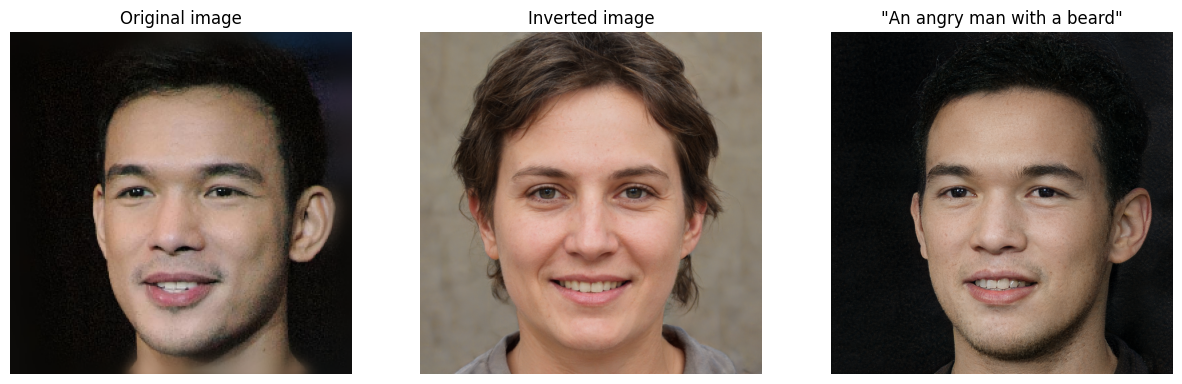

In [20]:
# Plot final image next to original image

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(imgs[0])
plt.title('Inverted image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(imgs[-1])
plt.title(f'"{prompt}"')
plt.axis('off')
plt.show()

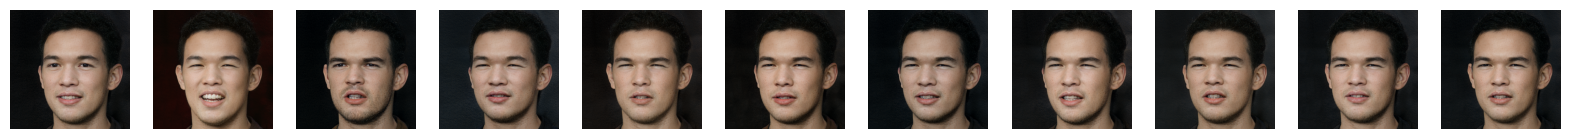

In [34]:
# Plot intermediate images

plt.figure(figsize=(20, 3))
for i in range(len(imgs)):
    plt.subplot(1, len(imgs), i + 1)
    plt.imshow(imgs[i])
    plt.axis('off')
plt.show()